## 对orders表的数据分析

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [51]:
# 导入orders
orders = pd.read_csv("orders.csv")
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)
orders_prior = orders.loc[orders['eval_set']=='prior']
orders_train = orders.loc[orders['eval_set']=='train']
orders_test = orders.loc[orders['eval_set']=='test']

In [55]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [11]:
# 各个子集的数量
set_cnt =  orders.groupby(orders['eval_set'])['order_id'].count()
for idx in set_cnt.index:
    print(idx, set_cnt[idx])

prior 3214874
test 75000
train 131209


In [22]:
# prior子集和train子集中的order_number
prior_ordnum = orders_prior.groupby(orders_prior['user_id'])[['order_number']].max()
train_ordnum = orders_train.groupby(orders_train['user_id'])[['order_number']].max()

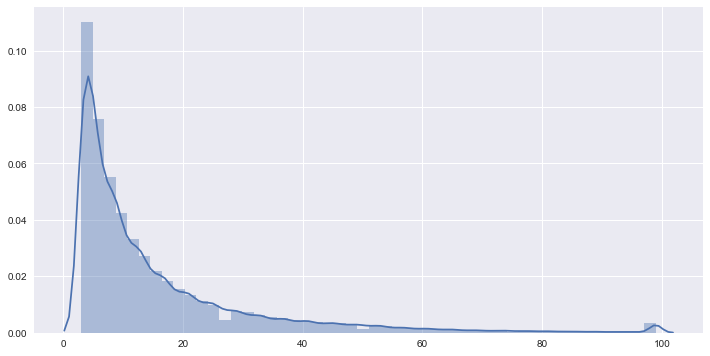

In [38]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.distplot(prior_ordnum, ax=ax0)

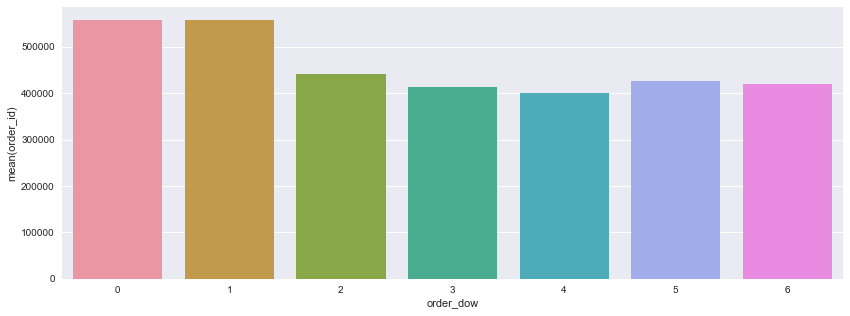

In [75]:
dow = orders_prior.groupby(orders_prior['order_dow'])['order_id'].count().to_frame().reset_index()
plt.figure(figsize=(14,5))
sns.barplot(data=dow, x='order_dow', y='order_id')

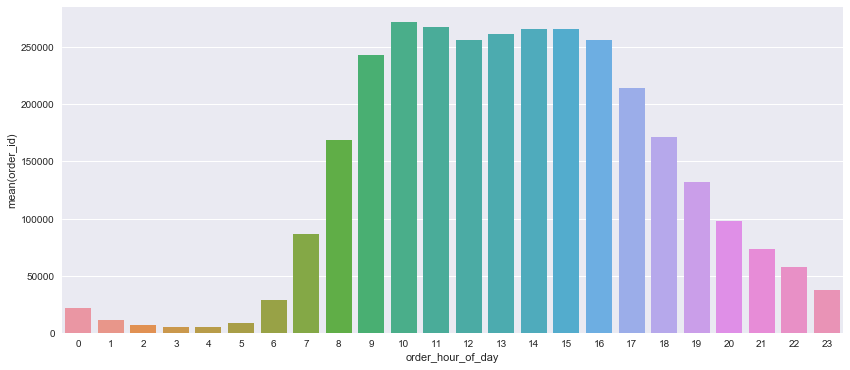

In [74]:
hour = orders_prior.groupby(orders_prior['order_hour_of_day'])['order_id'].count().to_frame().reset_index()
plt.figure(figsize=(14,6))
sns.barplot(data=hour, x='order_hour_of_day', y='order_id')

大家都在工作时间下单吗…

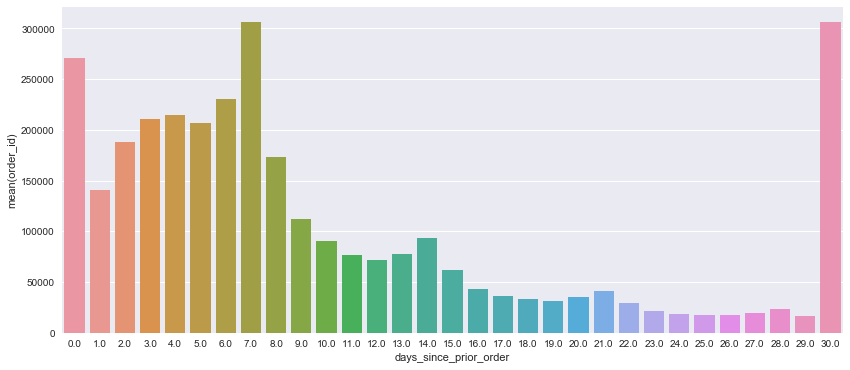

In [73]:
# days_since_prior_order
days_since_prior_order = orders_prior.groupby(orders_prior['days_since_prior_order'])['order_id'].count().to_frame().reset_index()
plt.figure(figsize=(14,6))
sns.barplot(data=days_since_prior_order, x='days_since_prior_order', y='order_id')